# ECC 
_______

**References:**
* [Elliptic Curve Cryptography: a gentle introduction](https://andrea.corbellini.name/2015/05/17/elliptic-curve-cryptography-a-gentle-introduction/)
* [[SEC1v2](https://www.secg.org/sec1-v2.pdf)] SEC 1: Elliptic Curve Cryptography (Version 2.0), [Standards for Efficient Cryptography Group (SECG)](https://en.wikipedia.org/wiki/SECG) founded by Certicom
* [[SEC2v2](http://www.secg.org/sec2-v2.pdf)] SEC 2: Recommended Elliptic Curve Domain Parameters (Version 2.0)
* [[GECC](https://link.springer.com/book/10.1007/b97644)] Guide to Elliptic Curve Cryptography, Darrel Hankerson, Alfred Menezes, and Scott Vanstone. 2004.

**Curves:**
* [https://safecurves.cr.yp.to](https://safecurves.cr.yp.to)
* [EdDSA Ed25519](https://tools.ietf.org/html/rfc8032)
    + https://ed25519.cr.yp.to/   
* [DH Curve25519](https://datatracker.ietf.org/doc/rfc7748/)
* [Brainpool curves](http://www.ecc-brainpool.org/download/Domain-parameters.pdf) (non-NIST)
* NIST curves specified in [FIPS 186-5](https://csrc.nist.gov/pubs/fips/186-5/final) and  [SP 800-186](https://csrc.nist.gov/pubs/sp/800/186/final)
* [Hyperelliptic](https://www.hyperelliptic.org/) calculation code snippets and implementation help

**Further reading:**
* [[GCAC](https://toc.cryptobook.us/)] A Graduate Course in Applied Cryptography, Dan Boneh and Victor Shoup
* [[CINTA](https://shoup.net/ntb/)] A Computational Introduction to Number Theory and Algebra, Victor Shoup
* [[HAC](https://cacr.uwaterloo.ca/hac/)] Handbook of Applied Cryptography, Alfred J. Menezes, Paul C. van Oorschot and Scott A. Vanstone
* [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)] Introduction to Modern Cryptography, Jonathan Katz and Yehuda Lindell (3rd Edition)

**Dependencies:**

This notebook uses [sage math](https://www.sagemath.org/) as kernel

In [1]:
import sage.misc.banner # sage math version info 
rchars = "┘─│┐┌└"
smallbanner = sage.misc.banner.banner_text(full=True)
for c in rchars:
    smallbanner = smallbanner.replace(c,"") # remove ascii art box
print(smallbanner)
#banner() # full banner with box


 SageMath version 9.5, Release Date: 2022-01-30                     
 Using Python 3.10.12. Type "help()" for help.                      



In [171]:
import secrets
import src.ecarithmetic as eca
import importlib 
importlib.reload(eca)

<module 'src.ecarithmetic' from '/workdir/src/ecarithmetic.py'>

In [172]:
# Helper functions
def gen_rand_int(min_value, max_value):
    """ Generate random integer x s.t. min_value <= x <= max_value """ 
    if min_value > max_value:
        raise ValueError("Lower bound must not exceed upper bound!")
    range_size = max_value - min_value + 1
    random_offset = secrets.randbelow(int(range_size))
    return int(min_value + random_offset)

In [2]:
# Global variables
SAVE_FIGURES=False # Do not save newly generated figures when run again

## ECC - Elliptic Curve Cryptography

* RSA relies on the hardness of *integer factorization*
* Diffie-Hellman relies on hardness of *discrete logarithm problem*
* ECC also relies on discrete logarithm problem, but over the algebraic structure of *elliptic curves over finite fields*. This makes the (same) problem harder
    + **Elliptic Curve Discrete Logarithm Problem** (ECDLP)

Advantage:
* Shorter key length without sacrificing high computational security
    + This means faster computation while retaining hardness against attacks
 
Some example algorithms making use of ECC: 
* Elliptic Curve Diffie-Hellman (ECDH)
* Elliptic Curve Digital Signature Algorithm (ECDSA)
* Edwars-curve Digital Signature Algorithm (EdDSA)

## Key sizes

* [Cryptographic key length recommendation](https://www.keylength.com/en/compare/)

<p style="text-align:center">
<img src="./figures/keylength.png" alt="key length" width="800">
</p>
<p style="text-align:center;font-size:10px">
<a href="https://upload.wikimedia.org/wikipedia/commons/1/17/Number-systems.svg">(image source)</a>
</p>

## Elliptic curves over finite fields
In ECC elliptic curves are defined **over some finite field** $\mathbb{F}$, i.e., the $x$ and $y$ coordinates of points on the elliptic curve have to be elements of the underlying finite field, i.e., $x,y \in \mathbb{F}$. 

An example for a finite field is the set of non-negative integers modulo a prime number $p$, i.e., $\mathbb{Z}_p$ where $ p \in \textrm{Primes}$. We denote this finite field with $\mathbb{F}_p$

## Elliptic curves representations
In ECC there are several different ways to express elliptic curves such as **Weierstrass**, **Montgomery**, and **(twisted) Edwards** representations. Different representations are used for reasons of *efficiency* and/or implementation-level *security*, such as, better resistence to side-channel attacks. 

The Montgomery ladder, which is only applicable to Edwards and Montgomery curves, is faster compared to standard weierstrass point multiplication methods. Moreover, the montgomery ladder is constant-time, while standard Weierstrass point multiplication methods are not. This enhances the resistance against timing side-channel attacks. 

Brier-Joye ladder allows for constant-time point multiplication on Weierstrass curves, but it is slower than the standard point multiplication method.

### (Long) Weierstrass represetation

An elliptic curve $E$ in (long) Weierstrass form is defined by the parameters $a_1,a_2,a_3,a_4,a_5 \in \mathbb{F}_p$ [[GECC](https://link.springer.com/book/10.1007/b97644)]:
$$
  y^2 + a_1xy + a_3y = x^3 + a_2x^2 + a_4x + a_5
$$

Together with a special *point at infinity* $\mathcal{O}=\infty$. The set of points on $E$ over finite field $\mathbb{F}_p$ is thus defined as:
$$
  E(\mathbb{F}_p) = \{(x,y) \in \mathbb{F}_p, y^2 + a_1xy + a_3y - x^3 - a_2x^2 - a_4x - a_5=0\} \cup \{ \mathcal{O} \}
$$

Every elliptic curve, with a characteristic ($p$) of the underlying finite field not equal to $ 2 $ or $ 3 $, can be transformed into Weierstrass form [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)].

### (Short) Weierstrass representation

The *simplified*, or *short*, Weierstrass form is a simplified representation of the long Weierstrass form which is commonly used instead of the long version as they can be transformed into each other [[GECC](https://link.springer.com/book/10.1007/b97644)].  

The simplified Weierstrass representation is defined by the parameters $a,b \in \mathbb{F}_p$: 
$$
    y^2 = x^3 + ax + b 
$$
Moreover, $a,b \in \mathbb{F}_p$ must satisfy $4a^3 + 27b^2 \not \equiv 0 \pmod p$.
This should ensure that the curve is **smooth**, i.e., the equation $ x^3 + ax + b = 0 $ has no repeated roots [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)][[SEC1v2](https://www.secg.org/sec1-v2.pdf)].

### Smooth and Singular curves

A smooth curve has *no sharp points*, *self-intersections*, or *singularities*. More formally, it is a curve in which every point has a well-defined tangent line, and the curve is differentiable at all points. For cryptographic applications we want curves to be smooth! 

*Singular curves* are **not** smooth. Singular points can take two forms:
1. **A node**: The curve intersects itself at a point. i.e., two distinct tangent lines intersect at the singular point.
2. **A cusp**: The curve bends sharply into itself, i.e., a single tangent line touches the curve with higher multiplicity.
Singular elliptic curves are no longer elliptic curves in the strict mathematical sense, as they fail to satisfy the smoothness condition.

**Example: Singular curve**

In [3]:
# y^2 = x^3 + a4x + a5
a1=0; a2=0; a3=0; a4=0; a5=0
try:
    EC = EllipticCurve(RR,[a1, a2, a3,a4 ,a5]) # Weierstrass curve
    p = plot(EC,thickness=3,xmin=-2,xmax=2,ymin=-2,ymax=2)
    p.show()
except ArithmeticError:
    print("ArithmeticError: Sage EllipticCurve won't even allow defining a singular curve!")

ArithmeticError: Sage EllipticCurve won't even allow defining a singular curve!


In [4]:
?implicit_plot

Signature:      implicit_plot(f, xrange, yrange, **options)
Docstring:     
   "implicit_plot" takes a function of two variables, f(x, y) and
   plots the curve f(x,y) = 0 over the specified "xrange" and "yrange"
   as demonstrated below.

   "implicit_plot(f, (xmin,xmax), (ymin,ymax), ...)"

   "implicit_plot(f, (x,xmin,xmax), (y,ymin,ymax), ...)"

   INPUT:

   * "f" -- a function of two variables or equation in two variables

   * "(xmin,xmax)" -- 2-tuple, the range of "x" values or
     "(x,xmin,xmax)"

   * "(ymin,ymax)" -- 2-tuple, the range of "y" values or
     "(y,ymin,ymax)"

   The following inputs must all be passed in as named parameters:

   * "plot_points" -- integer (default: 150); number of points to plot
     in each direction of the grid

   * "fill" -- boolean (default: "False"); if "True", fill the region
     f(x, y) < 0.

   * "fillcolor" -- string (default: "'blue'"), the color of the
     region where f(x,y) < 0 if "fill = True". Colors are defined in
     "sag

#### Singular elliptic cruve $y^2 = x^3$ with a cusp

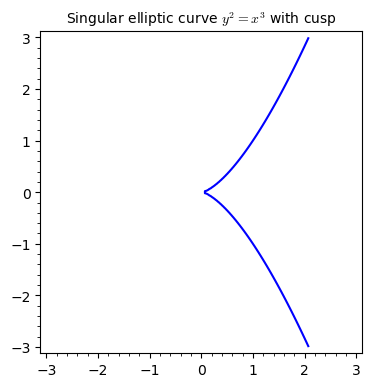

In [5]:
var('x y'); a = 0; b = 0 
func = y^2 - (x^3 + a*x + b) # y^2 = x^3 # (a cusp) 
p = implicit_plot(func, (x, -3, 3), (y, -3, 3), color='blue', title="Singular elliptic curve $y^2 = x^3$ with cusp")
p.show()

#### Singular elliptic cruve $y^2 = x^3 - 3x +2 $ with a node

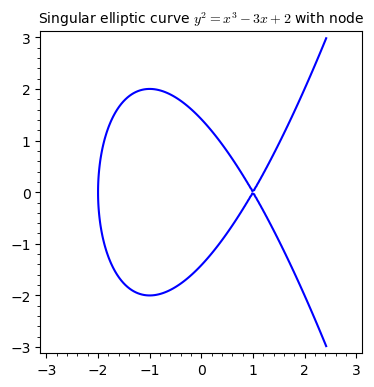

In [6]:
var('x y'); a = 3; b = 2 
func = y^2 - (x^3 - a*x + b) # y^2 = x^3 - 3x +2 # (a node) 
p = implicit_plot(func, (x, -3, 3), (y, -3, 3), color='blue', title="Singular elliptic curve $y^2 = x^3 - 3x +2 $ with node")
p.show()

## Elliptic curves over $\mathbb{R}$
The following illustration is often used to depict elliptic curves, but elliptic curves in cryptography are used over finite fields not the real numbers! Nevertheless, such representations are useful to explain the basic operations in ECC. 
* Simplified Weierstrass equation over the real numbers $\mathbb{R}$ with $a = -1$ and $b = 1$:
$$
y^2 = x^3 + ax + b 
$$

In [7]:
a=-1; b=1; a1=0;a2=0;a3=0; a4=a; a5=b; # define as long Weierstrass
EC = EllipticCurve(RR,[0, 0, 0,-1 ,1]) # Weierstrass curve
p = plot(EC,thickness=3,xmin=-2,xmax=2,ymin=-2,ymax=2)
if SAVE_FIGURES: p.save("./figures/ecc_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_over_R.png" alt="EC over R" width="350">
</p>

## Elliptic curves over $\mathbb{F}_p$

In ECC we define elliptic curves $E(\mathbb{F}_p)$ over $\mathbb{F}_p$ in simplified Weierstrass form as follows:

* Let $ \mathbb{F}_p $ be a prime finite field where $ p \in \textrm{Primes} $
* The parameters $a,b \in \mathbb{F}_p $
* Let $a,b \in \mathbb{F}_p$ satisfy $4a^3 + 27b^2 \not \equiv 0 \pmod p$
* The elliptic curve is set of solutions, i.e., points $ P=(x,y)$ on the curve, for all pairs $x,y \in \mathbb{F}_p$ to the defining equation:
$$
\begin{align*}
E(\mathbb{F}_p): y^2 \equiv x^3 + ax + b \pmod p \\
\end{align*}
$$
* Plus the point at infinity $\infty$ or $\mathcal{O} \in E(\mathbb{F}_p)$, s.t., $P + \mathcal{O} = \mathcal{O} + P = P $



In [8]:
p=103; assert p in Primes(); FF=FiniteField(p); # define finite field 

In [9]:
EllipticCurve?

Type:           EllipticCurveFactory
String form:    <sage.schemes.elliptic_curves.constructor.EllipticCurveFactory object at 0x7fb2d6db6020>
File:           /usr/lib/python3/dist-packages/sage/schemes/elliptic_curves/constructor.py
Docstring:     
   Construct an elliptic curve.

   In Sage, an elliptic curve is always specified by (the coefficients
   of) a long Weierstrass equation

      y^2 + a_1 xy + a_3 y = x^3 + a_2 x^2 + a_4 x + a_6.

   INPUT:

   There are several ways to construct an elliptic curve:

   * "EllipticCurve([a1,a2,a3,a4,a6])": Elliptic curve with given
     a-invariants. The invariants are coerced into a common parent. If
     all are integers, they are coerced into the rational numbers.

   * "EllipticCurve([a4,a6])": Same as above, but a_1=a_2=a_3=0.

   * "EllipticCurve(label)": Returns the elliptic curve over \QQ from
     the Cremona database with the given label. The label is a string,
     such as ""11a"" or ""37b2"". The letters in the label *must* be
 

In [10]:
a=-1; b=1; a1=0;a2=0;a3=0; a4=a; a5=b; # define as long Weierstrass
EC=EllipticCurve(FF,[a1,a2,a3,a4,a5]); EC

Elliptic Curve defined by y^2 = x^3 + 102*x + 1 over Finite Field of size 103

### Elliptic curves over $\mathbb{F}_p$
Note that elliptic curves over finite fields are no really "curves", but they are still *symmetric* along the $ x $ axis (because of $y^2$)
* Therefore, up to two solution for each $ x $ exist, i.e., $y$ and $-y$
* Therefore, for each point $P=f(x,y)$ a *symmetric inverse* $-P=f(x,-y)$ is defined

In [11]:
p=103; assert p in Primes();
EC=EllipticCurve(FiniteField(p), [0,0,0,-1,1]); 
p=plot(EC, size=40); 
p += line ([(0 , 52) ,(105,52)] , rgbcolor =(1 ,0 ,0)) # highlight symmetrie
if SAVE_FIGURES: p.save("./figures/ecc_over_F.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_over_F.png" alt="EC over F" width="350">
</p>

### Example: Compute the points on an elliptic curve 
The following is an example of how to compute all points on a small elliptic curve over $\mathbb{F}_p$, where $p = 103$

To compute the points on the elliptic curve over some finite field $\mathbb{F}_p$ we recall the defining equation in long Weierstrass and simplified Weierstrass form defined by the parameters:
* $a_1,a_2,a_3,a_4,a_5 \in \mathbb{F}_p$ (long Weierstrass), or
$$
\begin{align*}
  y^2 + a_1xy + a_3y \equiv x^3 + a_2x^2 + a_4x + a_6 \pmod p \\
  y^2 + a_1xy + a_3y - x^3 - a_2x^2 - a_4x - a_6 \equiv 0 \pmod p
\end{align*}
$$
The set of points on $E$ over $\mathbb{F}_p$ is thus defined as:
$$
  E(\mathbb{F}_p) = \{(x,y) \in \mathbb{F}_p, y^2 + a_1xy + a_3y - x^3 - a_2x^2 - a_4x - a_6=0\} \cup \{ \mathcal{O} \}
$$
* $a,b \in \mathbb{F}_p$ and $ $ (short Weierstrass)
$$
\begin{align*}
y^2 \equiv x^3 + ax + b \pmod p \\
y^2 - (x^3 + ax + b) \equiv 0 \pmod p 
\end{align*}
$$

The set of points on $E$ over $\mathbb{F}_p$ can thus be computed in sage math as follows:

In [12]:
EllipticCurve?

Type:           EllipticCurveFactory
String form:    <sage.schemes.elliptic_curves.constructor.EllipticCurveFactory object at 0x7fb2d6db6020>
File:           /usr/lib/python3/dist-packages/sage/schemes/elliptic_curves/constructor.py
Docstring:     
   Construct an elliptic curve.

   In Sage, an elliptic curve is always specified by (the coefficients
   of) a long Weierstrass equation

      y^2 + a_1 xy + a_3 y = x^3 + a_2 x^2 + a_4 x + a_6.

   INPUT:

   There are several ways to construct an elliptic curve:

   * "EllipticCurve([a1,a2,a3,a4,a6])": Elliptic curve with given
     a-invariants. The invariants are coerced into a common parent. If
     all are integers, they are coerced into the rational numbers.

   * "EllipticCurve([a4,a6])": Same as above, but a_1=a_2=a_3=0.

   * "EllipticCurve(label)": Returns the elliptic curve over \QQ from
     the Cremona database with the given label. The label is a string,
     such as ""11a"" or ""37b2"". The letters in the label *must* be
 

In [13]:
p=103; assert p in Primes(); FF=FiniteField(p);
a1=0;a2=0;a3=0; a4=-1; a5=1; EC=EllipticCurve(FF,[a1,a2,a3,a4,a5]); EC

Elliptic Curve defined by y^2 = x^3 + 102*x + 1 over Finite Field of size 103

In [14]:
len(EC.points()) # use built in sage math function

112

In [15]:
# naively compute all points on elliptic curve manually in sage
ec_points = list()
p=103; assert p in Primes();
for x in range(0,p):
    for y in range(0,p):
        if mod( y^2 - (x^3 - x + 1), p) == 0: 
            ec_points.append( (x,y) )
len(ec_points)

111

In [16]:
# naively compute all points on elliptic curve manually in python (cf. https://stackoverflow.com/questions/76143329/how-to-get-all-the-solution-points-over-a-finite-field-of-an-elliptical-curve)
ec_points = set(); p=103; assert p in Primes();
for x in range(0,p):
    for y in range(0,p):
        if (y**2 - (x**3 - x + 1)) % p == 0: 
            ec_points.add( (x,y) )
len(ec_points)

111

**Question:** Which point is missing?

In [17]:
ec_diff = list(); ec_match = list() # naively match points  
for Q in EC.points():
    match=False
    for P in ec_points:
        if not Q.is_zero() and Q.xy()[0] == P[0] and Q.xy()[1] == P[1]:
            ec_match.append({"P":P,"Q":Q})
            match=True
            break
    if not match:
        ec_diff.append(Q)

In [18]:
len(ec_match)

111

In [19]:
ec_diff # Point at infinity if ( x : y : 0 ) and 1 otherwise

[(0 : 1 : 0)]

In [20]:
ec_diff[0].is_zero() # check if point at infinity

True

### Number of points on elliptic curves over $\mathbb{F}_p$

The number of points $E(\mathbb{F}_p)$ on the elliptic curve $E$ over $\mathbb{F}_p$ is denoted by $\# E(\mathbb{F}_p)$, or $|E(\mathbb{F}_p)|$, and is called the *order* of the curve. This number is somewhat close to the prime $ p $ and can be approximated by the Hasse Theorem:
$$
p + 1 - 2 \sqrt{p} \leq \# E(\mathbb{F}_p) \leq p + 1 + 2 \sqrt{p}
$$

In [3]:
p=103; assert p in Primes(); FF=FiniteField(p); 
FF.order()  # order of the underlying FF

103

In [4]:
EC=EllipticCurve(FF,[0,0,0,-1,1]); EC

Elliptic Curve defined by y^2 = x^3 + 102*x + 1 over Finite Field of size 103

In [5]:
assert EC.order() == len(EC.points()); 
EC.order() # order of the EC

112

In [6]:
assert p+1-2*(p.sqrt()) <= EC.order() <= p+1+2*(p.sqrt()) # Hasse Theorem

### Generators for elliptic curves 
A generator $G$ of an elliptic curve has the same order as the curve and hence can *generate* all points on the curve:
$$
\{G,G\cdot 1,G \cdot 2,\dots,G \cdot \#E(\mathbb{F}_p)\}
$$

In [7]:
G = EC.gen(0); G.xy() 

(2, 78)

In [8]:
G # (x :  y : 0 iff point at infinity, 1 otherwise)

(2 : 78 : 1)

In [9]:
G.is_zero()

False

In [10]:
G*1 == G

True

In [11]:
G.order()

112

#### Generators for elliptic curves

In [12]:
EC.order()

112

In [13]:
print(G,G*2,G*111,G*112,G*113) # last point is the starting point G again

(2 : 78 : 1) (4 : 79 : 1) (2 : 25 : 1) (0 : 1 : 0) (2 : 78 : 1)


In [14]:
print(f"point at infinity = {G*112}") 

point at infinity = (0 : 1 : 0)


In [15]:
(G*112).is_zero()

True

## ECC operations 
<a id='ops'></a>
The following are some illustrations of basic elliptic curve operations on a *Weierstrass* curve, either over the real numbers $\mathbb{R}$, or the finite field $\mathbb{F}_{103}$:
$$
\begin{align*}
y^2 &= x^3 + ax + b \\
a &= -1 \\
b &= 1 
\end{align*}
$$

Due to the nature of the ECDLP, a important operation in elliptic curve cryptography is **point multiplication**, or *scalar multiplication*, which refers to the multiplication of a scalar value $k$ with a point $G$ on an elliptic curve over a finite field, to gain another point $Q$ which is also located  on the elliptic curve.
To perform these point multiplication operations, two main calculations are needed in general: *point addition* and *point doubling*.


### Inverse of a point
$$ 
\begin{align*}
P1 &= (x,y) = (1,1) \\
P2 &= -P1 = (x,-y) = (1,-1) \\
\end{align*}
$$

In [34]:
EC = EllipticCurve(RealField(53), [0 ,0 ,0 , -1 ,1]); EC
P1 = EC(1, 1); P2 = EC(1, -1) # define two points to add on curve
Q = P1 + P2  # calculate Q
p = EC.plot(thickness=3, xmin = -2 , xmax =2 , ymin = -2 , ymax =2)
p += point ([ P1 . xy () , P2 . xy ()] , size =60 , hue =0.1 , zorder =4)
p += line ([(P1.xy()[0] , -2) ,(P2.xy()[0] ,2)] , rgbcolor =(0 ,0 ,1))
p += text("P1",(1.20,1),fontsize=16, color='black')
p += text("P2",(1.20,-1),fontsize=16, color='black')
p += text("$y^2 = x^3 - x + 1$", (-1.3,-1.8), fontsize=20, color='black')
if SAVE_FIGURES: p.save("./figures/ecc_inverse_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_inverse_over_R.png" alt="EC inverse over R" >
</p>

### Point doubling
This operation refers to the addition of one point to itself, hence the name point doubling. 
$$
P+P=2P=Q
$$

In [35]:
# create elliptic curve over the Reals with 53 bit precision
EC = EllipticCurve(RealField(53), [0,0,0,-1,1]); EC
P = EC(1,1); Q = P*2; # define two points to add on curve
p = EC.plot(thickness=2,xmin=-2, xmax=2, ymin=-2, ymax=2)
p += point([P.xy(), Q.xy(), (-1.00000000000000, -1.00000000000000)],size=60, hue=0.1, zorder=4)
p += line([P.xy(),(-1.00000000000000, -1.00000000000000)],rgbcolor=(0,0,1))
p += line([(-1.00000000000000, -1.00000000000000),Q.xy()], linestyle="--", rgbcolor=(0,0,1))
p += text("P",(1.20000000000000, 1.00000000000000),fontsize=16, color='black')
p += text("Q",(-1.20000000000000, 1.00000000000000),fontsize=16, color='black')
p += text("-Q",(-1.20000000000000, -1.00000000000000),fontsize=16,color='black')
p += text("$y^2 = x^3 - x + 1$", (-1.3,-1.8), fontsize=20, color='black')
if SAVE_FIGURES: p.save("./figures/ecc_dbl_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_dbl_over_R.png" alt="EC inverse over R" >
</p>

The figure shows a geometrical example of point doubling on the elliptic curve $y^2 = x^3 - x + 1$ over the real numbers $\mathbb{R}$. 
From a geometrical perspective, point doubling on an elliptic curve works by drawing a tangent through the point to double. 
The point $-Q$ at the intersection of this tangent is the reflection of the result $Q$ over the x-axis. 
The equation for this calculation would be $2P=Q$.
If there is no such intersection point between tangent and curve, the result is defined as the *point at infinity* $2P = O$ or $2P = \infty$.


### Point doubling formular for $ Q = P + P $
$$
\begin{align*}
P &= \langle p_x, p_y \rangle \\
m &= \frac{3p_x^2 + a}{2p_y} \\
r_x &= m^2 - 2p_x \\
r_y &= m \cdot (p_x - r_x) - p_y \\
Q &= \langle r_x, r_y \rangle
\end{align*}
$$

For a good tutorial on the subject also see [ECC Introduction by Johannes Bauer](https://www.johannes-bauer.com/compsci/ecc/)

In [36]:
def point_double_sage(P,a): 
    # EC point doubleing in sage, this function works with 
    # x,y of points over the reals as well as over FF
    if P is None:
        return None 
    xp, yp = P
    m =  (3 * xp ** 2 + a) / (2 * yp) 
    xr =  m**2 - 2*xp 
    yr =  m * (xp - xr) - yp
    return (xr, yr)

In [37]:
def point_double_sage_v2(P,a):
    # EC point doubleing with sage notation
    if P is None:
        return None 
    xp, yp = P 
    m =  (3 * xp^2 + a) * (2 * yp)^(-1) 
    xr =  m^2 - 2*xp 
    yr =  m * (xp - xr) - yp
    return (xr, yr)

In [38]:
p = 31
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,-1,1]); EC # a=-1 b=1
P = EC.random_element(); P

(1 : 30 : 1)

In [39]:
Q_point = P + P; Q_point # sage point doubling simple implicit notation 

(30 : 30 : 1)

In [40]:
Q_xy = point_double_sage( P.xy(), a=FF(-1) ); Q_xy

(30, 30)

In [41]:
Q_xy = point_double_sage_v2( P.xy(), a=FF(-1) ); Q_xy

(30, 30)

In [42]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

In [43]:
assert point_double_sage_v2( P.xy(), a=FF(-1) ) == point_double_sage_v2(P.xy(),a=FF(-1))

In [44]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

#### Point doubling in pyton 

In [45]:
import src.ecarithmetic as eca
import importlib 
importlib.reload(eca)

<module 'src.ecarithmetic' from '/workdir/src/ecarithmetic.py'>

In [46]:
x1 = int(P.xy()[0])
y1 = int(P.xy()[1])
print((x1,y1),f"all coordinate values are of type {type(x1)}")

(1, 30) all coordinate values are of type <class 'int'>


In [47]:
Q_xy = eca.double_point((x1,y1),a=-1,p=p); Q_xy

(30, 30)

In [48]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

### Point doubling - Point at infinity 
In the visual example of point doubling the solution is the point at infinity $\mathcal{O}$. All vertical lines (e.g., additions) would also result in the point at infinity. 
$$
P+P=2P=\infty=\mathcal{O}
$$

In [49]:
# create elliptic curve over the Reals with 53 bit precision
EC = EllipticCurve(RealField(53), [0,0,0,-1,1]); EC
p = EC.plot(thickness=2,xmin=-2, xmax=2, ymin=-2, ymax=2)
p += point([(-1.33,0)],size=60, hue=0.1, zorder=4)
p += line( [(-1.33,0) ,(-1.33, 2),(-1.33, -2)],rgbcolor=(0,0,1))
p += text("P", (-1.45, 0.2) , fontsize=16, color='black')
p += text("$y^2 = x^3 - x + 1$", (-1.3,-1.8), fontsize=20, color='black')
if SAVE_FIGURES: p.save("./figures/ecc_dbl_infty_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_dbl_infty_over_R.png" alt="EC double to point at infinity over R" >
</p>

### Point addition
$$ 
\begin{align*}
P1 + P2 = Q
\end{align*}
$$

In [50]:
# create elliptic curve over the Reals with 53 bit precision
EC = EllipticCurve ( RealField (53) , [0 ,0 ,0 , -1 ,1]); EC
# define two points to add on curve
P1 = EC ( -1.20 , RealField (54)(1/25* sqrt (5)* sqrt (59))); P1
P2 = EC (0.0 ,1)
Q = P1 + P2 
Qinv = (Q.xy()[0], Q.xy()[1]*-1)
p = EC . plot ( thickness =2,xmin=-2 , xmax=2 , ymin=-2 , ymax=2)
p += point ([ P1 . xy () , P2 . xy () , Q . xy (), Qinv ], size =60 , hue =0.1 , zorder =4)
p += line([P1.xy(),Qinv])
p += line([Q.xy(),Qinv],linestyle="--") 

p += text("P1",(-1.40000000000000, 0.687022561492707),fontsize=16, color='black')
p += text("P2",(0.000000000000000, 1.20000000000000),fontsize=16, color='black')
p += text("Q",( Q.xy()[0] + 0.2, Q.xy()[1]),fontsize=16,color='black')
p += text("-Q",( Qinv[0] + 0.2, Qinv[1]),fontsize=16,color='black')
p += text("$y^2 = x^3 - x + 1$", (-1.3,-1.8), fontsize=20, color='black')
if SAVE_FIGURES: p.save("./figures/ecc_add_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_add_over_R.png" alt="EC inverse over R" >
</p>

This operation refers to the addition of two points $P1$ and $P2$ on an elliptic curve $E$ over the real field $\mathbb{R}$. 
The figure shows a geometrical example of point addition on the elliptic curve $y^2 =x^3-x+1$ over the real field $\mathbb{R}$. 
From a geometrical perspective point addition on an elliptic curve works by drawing a line through both points so that it intersects the elliptic curve at a third point $-Q$. 
This third point $-Q$ is the reflection over the x-axis of the result $Q$ on the elliptic curve. 
The equation for this calculation is, $P1+P2=Q$. 
If there is no such intersection point in a point addition, then the two points to add are reflections of one another over the x-axis, $P2 = -P1$. 
In such a case a line through both points does not intersect the elliptic curve in a third point. 
The result of such an addition is defined as the *point at infinity*, $P1 + (-P1) = O$ or $P1 + (-P1) = \infty$  

### Point addition over $\mathbb{F}_p$ 
This time we use $\mathbb{F}_{103}$ as underlying finite field:
$$ 
\begin{align*}
P1 + P2 = Q
\end{align*}
$$

In [51]:
p = 31
a = FF(-1)
b = FF(1)
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,a,b]); EC
P1 = EC.random_element()
P2 = EC.random_element()
print(P1.xy())
print(P2.xy())
P1x,P1y = P1.xy()
P2x,P2y = P2.xy()
m = mod( (P2y - P1y) / ( P2x - P1x ), p)
n = mod(P1y - m * P1x,p)

points=list()
for i in range(0,p):
    points.append( (i, (m*i + n) % p ) )
#print(points) 

#var('y x')
#p += implicit_plot(y == m * x + n,(x,0,53),(y,0,53))

Q = P1 + P2
Qinv = (Q[0],Q[1]*-1)

pl = plot(EC, size=60,ticks=[5,5])

pl += point ([ P1 . xy () , P2 . xy () , Q . xy (), Qinv ], size =60 , hue =0.1 , zorder =4)
pl += line([P1.xy(),P2.xy()]) # a direct line through boath input points (not always the actual line produced by the points)   
pl += line([Q.xy(),Qinv],linestyle="--") # the resulting point and its inverse
pl += point(points,marker="_") # the line(s) produces through the two points to add
if SAVE_FIGURES: pl.save("./figures/ecc_add_over_F.png")
#pl.show()

(1, 1)
(26, 25)


<p style="text-align:center">
<img src="./figures/ecc_add_over_F.png" alt="EC inverse over R" >
</p>

### Point addition formular for $ Q = P1 + P2 $
$$
\begin{align*}
P1 &= \langle p1_x, p1_y \rangle; P2 = \langle p2_x, p2_y \rangle \\
m &= \frac{p1_y - p2_y}{p1_x - p2_y} \\
r_x &= m^2 - p1_x - p2_x \\
r_y &= m \cdot (p1_x - r_x) - p1_y \\
Q &= \langle r_x, r_y \rangle
\end{align*}
$$

For a good tutorial on the subject also see [ECC Introduction by Johannes Bauer](https://www.johannes-bauer.com/compsci/ecc/)

In [16]:
def point_addition_sage(P1, P2, a):
    # EC point addition, this function works with 
    # x,y of points over the reals as well as over FF
    if P1 is None or P2 is None: # check for the zero point 
        return P1 or P2
    x1, y1 = P1
    x2, y2 = P2
    if x1 == x2:
        return point_double_sage(P1,a)
    m = (y1 - y2) / (x1 - x2)
    xr = m**2 - x1 - x2
    yr = m * (x1 - xr) - y1
    return (xr, yr)

In [53]:
def point_addition_sage_v2(P1, P2, a):
    # EC point addition in sage over some finite field mod p
    if P1 is None or P2 is None: # check for the zero point 
        return P1 or P2
    x1, y1 = P1
    x2, y2 = P2
    if x1 == x2:
        return point_double_sage_v2(P1,a)
    m =  (y1 - y2) * ( (x1 - x2) )^(-1) 
    xr = m^2 - x1 - x2   
    yr = y1 + m * (xr - x1) 
    return (xr, -yr )

In [54]:
p = 31; a = FF(-1); b = FF(1)
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,a,b]); EC
P1 = EC.random_element()
P2 = EC.random_element()
print(P1.xy())
print(P2.xy())
P1x,P1y = P1.xy()
P2x,P2y = P2.xy()

(0, 1)
(6, 26)


In [55]:
assert point_addition_sage(P1.xy(), P2.xy(), a) == point_addition_sage_v2(P1.xy(), P2.xy(), a)
assert point_addition_sage(P1.xy(), P2.xy(), a) == (P1 + P2).xy()

In [56]:
p = 31
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,-1,1]); EC # a=-1 b=1
P1 = EC.random_element(); P1

(11 : 22 : 1)

In [57]:
P2 = EC.random_element(); P2

(1 : 1 : 1)

In [58]:
Q_point = P1+P2; Q_point

(20 : 18 : 1)

In [59]:
Q_xy = point_addition_sage(P1.xy(),P2.xy(),a=FF(-1)); Q_xy

(20, 18)

In [60]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

In [61]:
Q_xy = point_addition_sage_v2(P1.xy(),P2.xy(),a=FF(-1)); Q_xy

(20, 18)

In [62]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

#### Point addition in python

In [63]:
import src.ecarithmetic as eca
import importlib 
importlib.reload(eca)

<module 'src.ecarithmetic' from '/workdir/src/ecarithmetic.py'>

In [64]:
x1 = int(P1.xy()[0])
y1 = int(P1.xy()[1])
x2 = int(P2.xy()[0])
y2 = int(P2.xy()[1])
print((x1,y1),(x2,y2),f"all coordinate values are of type {type(x1)}")

(11, 22) (1, 1) all coordinate values are of type <class 'int'>


In [65]:
Q_xy = eca.add_points((x1,y1),(x2,y2),a=-1,p=p); Q_xy

(20, 18)

In [66]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

### Point multiplication

Point multiplication, or scalar multiplication,  is an important operation in ECC. 
A simple algorithm for point multiplication is the binary method also called *right-to-left binary method*. 
Let $G=(x,y)$ be a point on an elliptic curve over $\mathbb{F}$, then point multiplication can be expressed as calculation of the following form: 

$$
    Q=kG=\overbrace{G+G+G+...+G}^{\text{k times G}}
$$

This chain of additions can be broken up into several multiplications and additions. 
For example if $k=17$ the chain of $G+G+G+...+G$ can be expressed as $(2\cdot (2\cdot (2\cdot (2\cdot G))))+G = 17\cdot G$. 
This reduces $17$ additions to $4$ multiplications and $1$ addition operation. 

In [67]:
var("g"); 2*2*2*2*g+g

17*g

As this algorithm demonstrates, the operations needed for point multiplication are *point addition* and *point doubling*. 
In ECC these two types of calculations have to be performed on elliptic curves that are defined over the finite field $\mathbb{F}_p$

### Point multiplication formular for $ Q = kG $
![binarymultiplication](./algorithms/binarymultiplication.png)

Algorithm for *point multiplication* from [[GECC](https://link.springer.com/book/10.1007/b97644)]

In [68]:
def point_multiplication_sage(k, P, a):
    result = None # Initialize with point at infinity 
    addend = P
    for b in [int(bit) for bit in bin(int(k))[2:][::-1]]: # from LSB to MSB
        if b:
            result = point_addition_sage(result, addend, a=a)
        addend = point_double_sage(addend, a=a)
    return result

#### Example: Point multiplication

In [69]:
p = 31
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,-1,1]); EC # a=-1 b=1
P = EC.random_element(); P

(25 : 16 : 1)

In [70]:
import random
k = random.randint(1,p); k

21

In [71]:
Q_point = k*P; Q_point

(6 : 5 : 1)

In [72]:
Q_xy = point_multiplication_sage(k, P.xy(), a=FF(-1) ); Q_xy

(6, 5)

In [73]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

#### Point multiplication in python

In [74]:
import src.ecarithmetic as eca
import importlib 
importlib.reload(eca)

<module 'src.ecarithmetic' from '/workdir/src/ecarithmetic.py'>

In [75]:
x = int(P.xy()[0])
y = int(P.xy()[1])
print((x,y),f"all coordinate values are of type {type(x)}")

(25, 16) all coordinate values are of type <class 'int'>


In [76]:
Q_xy = eca.double_and_add(k, (x,y), a=-1, p=p ); Q_xy

(6, 5)

In [77]:
assert Q_point.xy()[0] == Q_xy[0] and Q_point.xy()[1] == Q_xy[1]

## ECC domain parameters
In case of ECC over prime fields ($\mathbb{F}_p$), where $p \in \textrm{Prime}$, the following *domain parameters* have to be defined:
* $p$: The prime defining the field $\mathbb{F}_p$, under which the curve operates. All point operations $(+,\cdot)$ are taken modulo $p$
* $a,b$: Two integers which are the coefficients defining the curve $E$
* $G$: The generator- or base-point used as a starting point for multiplications.
* $n$: The *order* of $G$, which is the number of distinct points on the curve which can be computed by multiplying $G$ with a scalar value, i.e., $\{1 \cdot G, 2 \cdot G, 3\cdot G, \dots, (n-1) \cdot G\}$
* $\#E(\mathbb{F}_p)$: The *order* of the curve, i.e., the total number of points on the elliptic curve over $\mathbb{F}_p$.
* $h$: The cofactor, i.e., number of points on the elliptic curve divided by $n$. Ideally $ h = 1 $, thus the order of the generator equals the order of the curve. 

### Cofactor 
* If the cofactor $ h > 1 $, there might be multiple small subgroups. Attackers could exploit this in small subgroup attacks.
* Secure curves usually have $ h = 1 $, or a very small value (like 2, 4, or 8), and implementations must validate points to ensure they lie in the correct subgroup. This should ensure that the public key or shared secret lies in the subgroup generated by $G$
* When $ h=1 $, the group is cyclic and simple to reason about.

### Example: Secp256k1 
This is an example instanciation of curve *secp256k1* specified in [[SEC2v2](http://www.secg.org/sec2-v2.pdf)] and allowed in [[SP 800-186]](https://csrc.nist.gov/pubs/sp/800/186/final) for blockchain-related applications. 
The curve has the following short Weierstrass form: 
$$
    y^2 \equiv x^3 + 7 \pmod p 
$$

A popular implementation is [libsecp256k1](https://github.com/bitcoin-core/secp256k1) used in Bitcoin. 

Although the curve is used throughout the cryptocurrency community, not a lot of test vectory are available in public standards. Some test vectors can be found [here](https://crypto.stackexchange.com/questions/41316/complete-set-of-test-vectors-for-ecdsa-secp256k1) and [here](https://crypto.stackexchange.com/questions/784/are-there-any-secp256k1-ecdsa-test-examples-available), and [libsecp256k1](https://github.com/bitcoin-core/secp256k1/blob/master/src/tests.c).

In [2]:
# Secp256k1 from https://www.secg.org/sec2-v2.pdf
p=2**256 - 2**32 - 2**9 - 2**8 - 2**7 - 2**6 - 2**4 - 1
a=0;b=7
x_G=0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798
y_G=0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8
n=0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141
h=1
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,a,b]); EC
G = EC.point((x_G,y_G))

#### Sanity checking of the curve
The *trace* of an ellipcit curve over a finite field is defined as $ t = p + 1 - | E(\mathbb{F}_o) |$ [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)]. Since the order of a curve can be computed efficiently this can be a first sanity check if everything has been defined correctly. 

In [3]:
t=p+1 - EC.order(); t 

432420386565659656852420866390673177327

In [4]:
EC.trace_of_frobenius() # also available as function in sage

432420386565659656852420866390673177327

In [20]:
assert EC.order() == G.order() * h == n * h

In [82]:
SK = 104180048334815325830625441518578326979476797852517177973225433558381925820558
PK = SK * G
(hex(PK[0]),hex(PK[1]))

('0x4e7927e13423b2afa70f1299ad041978e55a1d9af1860a826ddb15024ed7da2',
 '0xd369291d811f2df550b1153d12ca5d3132b7f2e658a90300c0daa39a476db17c')

In [83]:
PK

(2218404120244963262942688441315034122895494739329766368892963870531381984674 : 95623813759907722199505071633719440492035181416518679137887147878608899256700 : 1)

#### Pitfall: Encoding of k in python

As I have observed this in multiple (broken) student challenges already, here a short reminder: 

In [84]:
k = int.from_bytes(bytes.fromhex('5f6b5c9588955286ea5cac4cd8c42f3d55a0e29c8af2bfeba487cf9d44b42954'),"big")
print(k); Q = k * G; Q

43159412243421451483526775168090392406101811960614411036878899673868778350932


(41858324777353967549034659156569719092956488814023218795456365288203237979134 : 16555327082719145925295244286557372390265073495347636540557744407873083411827 : 1)

In [85]:
k = 0x5f6b5c9588955286ea5cac4cd8c42f3d55a0e29c8af2bfeba487cf9d44b42954
print(k); Q = k * G; Q

43159412243421451483526775168090392406101811960614411036878899673868778350932


(41858324777353967549034659156569719092956488814023218795456365288203237979134 : 16555327082719145925295244286557372390265073495347636540557744407873083411827 : 1)

In [86]:
k = int(b"5f6b5c9588955286ea5cac4cd8c42f3d55a0e29c8af2bfeba487cf9d44b42954".hex()) # not the same as above! 
print(k); Q = k * G; Q

35663662356339353838393535323836656135636163346364386334326633643535613065323963386166326266656261343837636639643434623432393534


(6346784422212244868555555448238701692585486454164203330957839538451111753464 : 105142884008388094226859483825865276832550578194178528738622802579099407956150 : 1)

## ECDH
____
<a id='ecdh'></a>

### ECDH 
**Elliptic Curve Diffi-Hellman** (ECDH) is a key agreement protocol that can be used as its *finite field* (aka. *algebraic*) counterpart. 
The major difference is the specification and operation over some elliptic curve defined by the domain parameters 
$(p,a,b,G,n,h)$. The goal is it to establish a shared secret over some public channel as follows: 
* Alice and Bob pick secret keys $d_A,d_B \in [1,n-1]$
* Alice computes his public key $ Q_A = d_A \cdot G$ and sends it to Bob
* Bob computes his public key $ Q_B = d_B \cdot G$ and sends it to Alice
* Alice computes the shared key (point) $ SK = d_A \cdot Q_B $
* Bob computes the shared key (point) $ SK = d_B \cdot Q_A $
* They end up with the same point because $ d_A \cdot Q_B = d_A \cdot d_B \cdot G = d_B \cdot d_A \cdot G = d_B \cdot Q_A $
* They can now use the $ x $ coordinate of the shared point to derive further keying material, e.g., for encryption

#### Example: ECDH

In [132]:
def ecdh(p,a,b,P,d):
    FF = FiniteField(p)
    EC = EllipticCurve(FF, [0,0,0,a,b])
    P = EC.point(P)
    return d * P

In [173]:
# Domain parameters for secp256k1 from https://www.secg.org/sec2-v2.pdf
p=2**256 - 2**32 - 2**9 - 2**8 - 2**7 - 2**6 - 2**4 - 1
a=0; b=7; n=0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141
x_G=0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798
y_G=0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8
G = (x_G, y_G)

#### Example: ECDH 

In [176]:
d_A  = gen_rand_int(int(1),int(n-1)) # secret key (sk) Alice
d_B  = gen_rand_int(int(1),int(n-1)) # secret key (sk) Bob
Q_A  = ecdh(p,a,b,G,d_A) # public key (pk) Alice
Q_B  = ecdh(p,a,b,G,d_B) # public key (pk) Bob
SK_A = ecdh(p,a,b,Q_B,d_A) # shared secret (SK) computed by Alice 
SK_B = ecdh(p,a,b,Q_A,d_B) # shared secret (SK) computed by Bob
print(f"SK_A   = {SK_A}")
print(f"SK_B   = {SK_B}")
print(f"x_k    =  {SK_A[0]}") # shared secret x of point

SK_A   = (103311599230891244196141501519719295246318952618282194758791088695620770368340 : 42089362789046722136743999528395994150103720055565281477524014906859215400990 : 1)
SK_B   = (103311599230891244196141501519719295246318952618282194758791088695620770368340 : 42089362789046722136743999528395994150103720055565281477524014906859215400990 : 1)
x_k    =  103311599230891244196141501519719295246318952618282194758791088695620770368340


In [149]:
assert SK_A[0] == SK_B[0]

## ECDSA
______
<a id='ecdsa'></a>

### ECDSA - Signature creation
Given a curve $(p,a,b,G,n)$, and a secret key $d_A$ (a scalar value):
* Compute the public key $Q_A = d_A \cdot G$
* Compute hash of the data/message to be signed $ e = hash(m)$
* Compute the first part of the signature, ephemeral key pair $(k,R)$:
  + Generate a *random nonce* k such that $0 < k < n$
  + Calculate point
    $$
        R = k \cdot G = \binom{r_x}{r_y}
    $$
  + Generate $r = r_x \pmod n$, where $ r \not = 0 $
* Generate the rest of the signature:
    $$
        s = \frac{e+d_A \cdot r}{k} \pmod n = k^{-1}\cdot(e+d_A \cdot r) \pmod n  
    $$
* Publish the signature $\textbf{(r,s)}$ together with the public key $Q_A$

### ECDSA - Signature verification
Given a curve $(p,a,b,G,n)$, a public key $Q_A$ together with a signature $(r,s)$.
The signature $(r,s)$ over $ m $ is valid iff:
* The signature values are plausible, i.e., $0 < r < n$ and $0 < s < n$
* (Re-)compute the hash of the data/message $e = hash(m)$
* Invert $s$ modulo $n$, i.e., $w = s^{-1} \pmod n$
  + Since $n$ is known and especially since $n \in \textrm{Primes}$, finding the multiplicate inverse $s^{-1}$ can be done in poly. time
  + Note: $s^{-1}$ can also be written as $1/s$
* Calculate $u_1 = e\cdot w \pmod n$, and $u_2 = r\cdot w \pmod n$
* Derive point $P$:
  $$
    P = \binom{p_x}{p_y} = u_1\cdot G + u_2 \cdot Q_A
  $$
* If $p_x = r \pmod n $, the signature is valid

### ECDSA - Signature verification
Given a curve $(p,a,b,G,n)$, a public key $Q_A$ together with a signature $(r,s)$.
The signature checking algorithm for $(r,s)$ over $m$ is correct because:
$$
\begin{align*}
P  &= u_1 \cdot G + u_2 \cdot Q_A \\
u_1 &= e \cdot w \text{ and } \\
u_2 &= r \cdot w \\
P  &= e \cdot w \cdot G + r \cdot w \cdot Q_A \\
P  &= e \cdot w \cdot G + r \cdot w \cdot d_A \cdot G \\
P  &= (e \cdot w + r \cdot w \cdot d_A) \cdot G \\
P  &= w \cdot (e + r \cdot d_A) \cdot G \\
w  &= s^{-1} = \left(\frac{e+d_A\cdot r}{k}\right)^{-1} = (({e + d_A \cdot r})\cdot k^{-1})^{-1} \pmod n \\
P  &=  (({e + d_A \cdot r})\cdot k^{-1})^{-1} \cdot (e + d_A \cdot r) \cdot G \\
P  &=  ({e + d_A \cdot r})^{-1} \cdot (k^{-1})^{-1} \cdot (e + d_A \cdot r) \cdot G = k \cdot G 
% alternative notation:
%w  &= s^{-1} = \left(\frac{e+d_A\cdot r}{k}\right)^{-1} = \frac{k}{e + d_A \cdot r} \pmod n \\
%P  &= \frac{k}{e + d_A \cdot r}\cdot (e + d_A \cdot r) \cdot G = k \cdot G 
\end{align*}
$$

### ECDSA - Nonce reuse
Do not reuse nonces in ECDSA!
* **n-on-ce** = **n**umber **on**ly use on**ce**
* Either derive from secure RNG or deterministically
  + http://tools.ietf.org/html/rfc6979
  + In [EdDSA](https://datatracker.ietf.org/doc/html/rfc8032#section-8.2) deterministic nonces are the default


### ECDSA - Nonce reuse
**Example:** Sony PS3 ECDSA nonce reuse vulnerability
* PS3 used code signing to only allow code from trusted sources to be executed
* Nonce was reused
* Secret key was recovered
* After fail0verflow presented the attack at [27c3](https://events.ccc.de/congress/2010/Fahrplan/events/4087.en.html) George Hotz (geohot) released the private key of the PS3 together with a "Hello  world program" for the PS3
* [Lawsuits followed](https://en.wikipedia.org/wiki/PlayStation_3_homebrew)
* [Now the case is settled](https://en.wikipedia.org/wiki/Sony_Computer_Entertainment_America,_Inc._v._Hotz)

<p style="text-align:center">
<img src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Free-speech-flag-ps3.svg" alt="PS3 key" width="128">
</p>
<p style="text-align:center;font-size:10px">
<a href="https://upload.wikimedia.org/wikipedia/commons/7/7d/Free-speech-flag-ps3.svg">PS3 code signing private key encoded as image (image source)</a>
</p>


<p style="text-align:center">
<img src="./img/nonce.png" alt="PS3 meme" width="600">
</p>

### ECDSA - Nonce reuse 
**Example:** Bitcoin online web wallet *Counterwallet.io* (2014)
* Used the same nonce for multiple signatures
* Multiple users transferred coins with the same $ r $ value [[1](https://bitcointalk.org/index.php?topic=581411.0),[2](https://bitcointalk.org/index.php?topic=395761.msg6354587#msg6354587)]. 

<p style="text-align:center">
<img src="./img/nonce_bitcoin.png" alt="PS3 key" width="765">
</p>
<p style="text-align:center;font-size:10px">
<a href="https://bitcointalk.org/index.php?topic=581411.0">(image source)</a>
</p>

### ECDSA - Nonce reuse
<a id='nonce'></a>
Given a curve $(p,a,b,G,n)$, a public key $Q_A$ together with:
* a signature $(r,s_1)$ and a message $m_1$
* a signature $(r,s_2)$ and a message $m_2$

It can be observed that both signatures used the same value $r$ and hence the same random value $k$.
This can be used to reconstruct the private key $d_A$

### ECDSA - Nonce reuse
The only unknown variables in the this two equations $(1)$ and $(2)$ are $k$ and $d_A$.
To solve for $d_A$ first rearrange the equations to $(3)$ and $(4)$ and replace $k$ in $(5)$. 

$$
\begin{align}
s_1 &= \frac{e_1+d_A \cdot r}{k} \pmod n \\
s_2 &= \frac{e_2+d_A \cdot r}{k} \pmod n \\
k &= \frac{e_1+d_A \cdot r}{s_1} \pmod n \\
k &= \frac{e_2+d_A \cdot r}{s_2} \pmod n \\
\frac{e_1+d_A \cdot r}{s_1} &= \frac{e_2+d_A \cdot r}{s_2} \pmod n
\end{align}
$$

Then solve for $d_A$:
$$
\begin{align*}
\frac{e_1+d_A \cdot r}{s_1} &= \frac{e_2+d_A \cdot r}{s_2} &\pmod n \\
s_2 \cdot (e_1+d_A \cdot r) &= s_1 \cdot (e_2+d_A \cdot r) &\pmod n \\
s_2 \cdot e_1 + s_2 \cdot d_A \cdot r &= s_1 \cdot e_2 + s_1 \cdot d_A \cdot r &\pmod n \\
s_2 \cdot e_1 - s_1 \cdot e_2  &= s_1 \cdot d_A \cdot r - s_2 \cdot d_A \cdot r &\pmod n \\
s_2 \cdot e_1 - s_1 \cdot e_2  &= d_A \cdot r \cdot ( s_1 - s_2 ) &\pmod n \\
\frac{s_2 \cdot e_1 - s_1 \cdot e_2}{r \cdot ( s_1 - s_2 )} &= d_A   &\pmod n \\
\end{align*}
$$

### ECDSA - Example usage with secp256k1
The following is an example of ECDSA using curve *secp256k1*.

In [87]:
load("./src/ecdsa.sage")

```python
def ecdsa_hashtoint(msg):	
  return Integer('0x' + hashlib.sha256(msg.encode()).hexdigest())
```

In [88]:
message_hash = ecdsa_hashtoint("some string"); hex(message_hash)

'0x61d034473102d7dac305902770471fd50f4c5b26f6831a56dd90b5184b3c30fc'

```python
def ecdsa_keygen(verbose=False):
  d = randint(1, n - 1)
  Q = d * G
  return (Q, d)
```

In [89]:
(Q_A,d_A) = ecdsa_keygen(verbose=True) # generate keypair 

d   = 0x96a01521e7b28bff0f6e062294c44d192e4d47c216bf105ef3ba47cd40f254a4
Q_x = 0x20aa48b4f7834f26c96d051a841a9e29c8df6d2e479f8c51c142dbb0a1b7ad4e
Q_y = 0x39eaa8214e17938f717d2ea951e85cd01d77067c10ebc1e8dd59c377e2383450


```python
def ecdsa_sign(d, m, nonce=None):
  r = 0; s = 0
  while s == 0:
    while r == 0:
      if nonce:
        k = nonce # for simulating nonce reuse attack!
      else:
        k = randint(1, n - 1)
      R = k * G
      (x1, y1) = R.xy()
      r = Fn(x1)
    e = Fn(m) # assume hashed message
    s = Fn(k) ^ (-1) * (Fn(e) + Fn(d) * Fn(r))
  return (r, s)
```

In [90]:
(r,s) = ecdsa_sign(d_A,message_hash,verbose=True)

k   = 0x4dfe7bad1b120d36f547002d61086657dc92b8797dbff19d1dc70e1f83c64586
G_x = 0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798
G_y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8
e   = 0x61d034473102d7dac305902770471fd50f4c5b26f6831a56dd90b5184b3c30fc
r   = 0x2f637666a8cbd30b3b0d6c66947c83e160df432ab98434aad4e4fee9d166344a
s   = 0x5339e3d0ca1a114e7304e115366adc50f24168327a6e27d4c68293f2c5e6071


```python
def ecdsa_verify(Q, m, r, s, verbose=False):
  e = Fn(m) # assume hashed message
  w = Fn(s) ^ (-1)
  u1 = (e * w)
  u2 = (r * w)
  P1 = Integer(u1) * G
  P2 = Integer(u2) * Q
  P = P1 + P2
  (x, y) = P.xy()
  p_x = Fn(x)
  return p_x == r
```

In [91]:
assert True == ecdsa_verify(Q_A, message_hash, r, s, verbose=True)

w   = 0xfddc1b7d2aaae3eae2182e1fd3dd407b2c33ce56816729ab20e3b4a20d37282d
e   = 0x61d034473102d7dac305902770471fd50f4c5b26f6831a56dd90b5184b3c30fc
u1  = 0x57426b9a4d7cc965ec4184301143a2926f6592fdaf9c017b11371de821486f11
u2  = 0xe8e2e9db6337b1ced787b21055e83b0420eb1791cb7f5ab26ca6c7105050fa5d
r   = 0x2f637666a8cbd30b3b0d6c66947c83e160df432ab98434aad4e4fee9d166344a
p_x = 0x2f637666a8cbd30b3b0d6c66947c83e160df432ab98434aad4e4fee9d166344a


In [92]:
message_hash = ecdsa_hashtoint("other message")
assert False == ecdsa_verify(Q_A, message_hash, r, s, verbose=False)

#### ECDSA - Nonce reuse using secp256k1

In [93]:
e1 = ecdsa_hashtoint("some string")
same_nonce = 18028843120798948533673493337980837983774482433016311482792706326465477485859
(r1,s1) = ecdsa_sign(d_A, e1, nonce=same_nonce,verbose=False)
print(f"r1 = {hex(r1)}\ns1 = {hex(s1)}")

r1 = 0x8362f4339944b91019606dd91522abc23d653a28cc899437f5109a1d1ceb4641
s1 = 0xfe104e0eb83c9397798e7fefe813b40e551dfa1cbbfd62aa885209341a81cda4


In [94]:
e2 = ecdsa_hashtoint("some other string")
same_nonce = 18028843120798948533673493337980837983774482433016311482792706326465477485859
(r2,s2) = ecdsa_sign(d_A, e2, nonce=same_nonce,verbose=False)
print(f"r2 = {hex(r2)}\ns2 = {hex(s2)}")

r2 = 0x8362f4339944b91019606dd91522abc23d653a28cc899437f5109a1d1ceb4641
s2 = 0x6ac10906fcf21c74104ac4dafde0c312f740eb92703ce466dafe224e05b06efc


In [95]:
assert r1 == r2

ECDSA nonce reuse calculation: 
$$
\frac{s_2 \cdot e_1 - s_1 \cdot e_2}{r \cdot ( s_1 - s_2 )} = d_A
$$

In [96]:
d_recovered = (s2 * e1 - s1 * e2)/(r1 * (s1 - s2))

In [97]:
d_A

68129768668606611660207536433936544511679163492021451989854272372038847059108

In [98]:
d_recovered

68129768668606611660207536433936544511679163492021451989854272372038847059108

In [99]:
assert d_A == d_recovered

# Optimizations in ECC
______

## Optimizations in ECC
Different representations of curve points, or optimized elliptic curves and parameters can lead to significant performance gains. For example, reduce the size to represent points on the curve (*point compression*), or speed up the computations required for ECC (e.g., *projective coordinates* and special curves). In the following we will take a look at some of these optimization techniques.

## Affine and Projective Coordinates
There are alternative ways to represent points on elliptic curves using *projective coordinates*.

* When a point on an elliptic curve is described by a pair of elements $(x,y)$ this is called *affine coordinates*

* When a point is represented by *three* alements (from $\mathbb{Z}_p$) then it is given in *projective coordinates* $(X,Y,Z) \in \mathbb{Z}_p$

### Projective coordinates 
A point is given by $(X,Y,Z) \in \mathbb{Z}_p$, where
* $X/Z = x \pmod p$
* $Y/Z = y \pmod p$
* The point at infinity $\mathcal{O}$ is given by $(0,Y,0)$ where $Y \neq 0 $ and this is the only point where $Z=0$
* To translate between *affine* and *projective* any point $(x,y) \neq \mathcal{O}$ becomes $(x,y,1)$ in projective coordinates and $(X,Y,Z)$ where $Z\neq0$ in projective coordinates can be mapped to $(X/Z \pmod p, Y/Z \pmod p)$ in affine coordinates.

### Projective coordinates addition
One advantage of using projective coordinates is that adding two points can now be done *without computing inverses* modulo $p$ which is the most expensive operation [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)]
$$
\begin{align}
P_3 &= P_1 + P_2 \\
(X_3,Y_3,Z_3) &= (X_1,Y_1,Z_1) + (X_2,Y_2,Z_2) \\
u &= Y_2 Z_1 - Y_1 Z_2 \\
v &= X_2 Z_1 - X_1 Z_2 \\
w &= u^2 Z_1 Z_2 - v^3 - 2v^2 X_1 Z_2 \\
(X_3,Y_3,Z_3) &= (vw, u(v^2 X_1 Z_2 - w) - v^3 Y_1 Z_2, Z_1 Z_2 v^3 )
\end{align}
$$

In [100]:
p = 31
FF = FiniteField(p)
EC = EllipticCurve(FF, [0,0,0,-1,1]); EC # a=-1 b=1
P1 = EC.random_element(); 
P2 = EC.random_element();
P1,P2

((16 : 19 : 1), (28 : 15 : 1))

In [101]:
x,y,z = P1; x,y,z

(16, 19, 1)

In [102]:
type(x)

<class 'sage.rings.finite_rings.integer_mod.IntegerMod_int'>

In [103]:
def add_projective(P1, P2, p):
    X1,Y1,Z1 = P1
    X2,Y2,Z2 = P2
    u = Y2 * Z1 - Y1 * Z2 % p
    v = X2 * Z1 - X1 * Z2 % p
    w = u**2 * Z1 * Z2 - v**3 - 2*v**2 * X1 * Z2 
    X3 = v*w 
    Y3 = u * (v**2 * X1 * Z2 - w) - v**3 * Y1 * Z2 
    Z3 = Z1 * Z2 * v**3 
    return ( X3/Z3,Y3/Z3,1 ) # translate to affine and return

In [104]:
P3_proj = add_projective(P1, P2, p); P3_proj

(25, 15, 1)

In [105]:
P3 = P1 + P2; P3

(25 : 15 : 1)

In [106]:
assert P3.xy() == (P3_proj[0],P3_proj[1])

## Montgomery representation
The montgomery representation involves elliptic curve equations ($E$) of the following form: 
$$
   By^2 = x^3 + Ax^2 + x \pmod p
$$
Here $B\neq 0 \pmod p$ and $ A \neq \pm 2 \pmod p $. Given this elliptic curve equation, we again denote $E(\mathbb{Z}_p)$ the set of points with coordinates $x,y \in \mathbb{Z}_p$ satisfying the equation $E$, together with a point at infinity $\mathcal{O}$.

Not every curve can be expressed in Montgomery representation (the order of any elliptic curve group written in Montgomery form is a multiple of $ 4 $ [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)]). 

### Montgomery curves over $\mathbb{R}$ 

The following figure shows the Montgomery curve $By^2 = x^3 + Ax^2 + x$ for $A=1/4$ and $B=5/2$ over $\mathbb{R}$.

<p style="text-align:center">
<img src="./figures/ecc_montgomery_over_R.png" width="500" height="400" alt="Montgomery over R" >
</p>

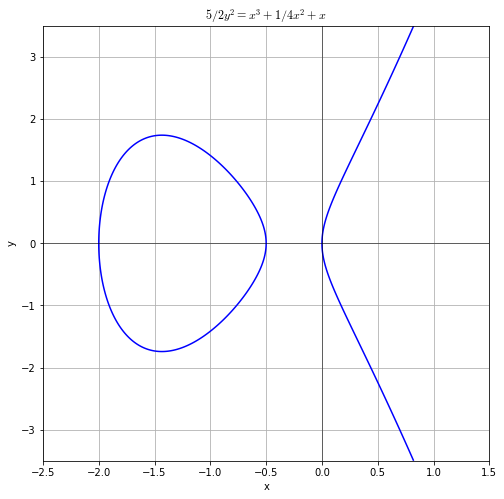

In [107]:
import numpy as np
import matplotlib.pyplot as plt

B = 5/2
A = 1/4
def equation(x, y):
    # x**3 + B*x**2 + x - A*y**2 == 0
    return x**3 + B*x**2 + x - A*y**2

# Create a grid of x and y values
x = np.linspace(-2.5, 1.5, 500)
y = np.linspace(-3.5, 3.5, 500)
X, Y = np.meshgrid(x, y)

# Calculate Z values based on the equation
Z = equation(X, Y)

# Plot the contour where Z = 0
plt.figure(figsize=(8, 8))
plt.contour(X, Y, Z, levels=[0], colors='blue')
plt.title(rf"${B}y^2 = x^3 + {A}x^2 + x$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
if SAVE_FIGURES: plt.savefig("./figures/ecc_montgomery_over_R.png",format="png", dpi=300)
#plt.show()

### Computation in Montgomory curves
TODO Montgomery ladder

### Example: Curve25519
The following is the *Montgomery curve* used for Curve25519, specified in [RFC 7748](https://datatracker.ietf.org/doc/rfc7748/) over $\mathbb{F}_p $ where $ p = 2^{255} - 19$.
$$
y^2 = x^3 +  486662 x^2 + x \pmod p
$$
This curve is *birationally equivalent* to a twisted Edwards curve $ -x^2 + y^2 = 1 + dx^2y^2 $, called *edwards25519*, where $ d = 37095705934669439343138083508754565189542113879843219016388785533085940283555 $ 

In [108]:
#d = 37095705934669439343138083508754565189542113879843219016388785533085940283555

For further information see:
* Nameing: https://mailarchive.ietf.org/arch/msg/cfrg/-9LEdnzVrE5RORux3Oo_oDDRksU/
* Homepage https://cr.yp.to/ecdh.html
  + The paper https://cr.yp.to/ecdh/curve25519-20060209.pdf
  + Optimization https://cr.yp.to/ecdh/curvezero-20060726.pdf
* Things that use Curve25519 https://ianix.com/pub/curve25519-deployment.html
  + [age](https://github.com/FiloSottile/age)
* Implementation description https://martin.kleppmann.com/papers/curve25519.pdf

In [109]:
B=1; A=486662
Curve25519 = EllipticCurve(GF(2^255-19),[0,A,0,B,0]) 
Curve25519

Elliptic Curve defined by y^2 = x^3 + 486662*x^2 + x over Finite Field of size 57896044618658097711785492504343953926634992332820282019728792003956564819949

In [110]:
Curve25519.trace_of_frobenius()

-221938542218978828286815502327069187962

In [111]:
assert Curve25519.trace_of_frobenius() == -221938542218978828286815502327069187962

#### Example: Curve25519 over $\mathbb{R}$

This is how the montgomery curve25519 looks over the real numbers $\mathbb{R}$

In [112]:
EC = EllipticCurve(RR,[0,A,0,B,0]) # Montgomery curve used for Curve25519
p = plot(EC,thickness=3) #p = plot(EC,thickness=3,xmin=-500000,xmax=2,ymin=-2,ymax=2)
if SAVE_FIGURES: p.save("./figures/ecc_curve25519_over_R.png")
#p.show()

<p style="text-align:center">
<img src="./figures/ecc_curve25519_over_R.png" alt="Curve25519 over R" >
</p>

## Twisted Edwards representation
The twisted Edwards representation involves elliptic curve equations ($E$) of the following form:
$$
   ax^2 + y^2 = 1 + dx^2y^2 \pmod p 
$$
Here $a,d \neq 0 \pmod p$ and $ a ¸\neq d \pmod p$. The special case where $ a = 1 $ is called the *Edwards representation* (without the "*twist*" $ a $). Given this elliptic curve equation, we again denote $E(\mathbb{Z}_p)$ the set of points with coordinates $x,y \in \mathbb{Z}_p$ satisfying the equation $E$, but this representation does not require a special point at infinity since the point $(0,1)$ on the curve is the identity element. 

The twisted Edwards representation can express the same set of elliptic curves as the Montgomery representation [[ITMC](https://www.cs.umd.edu/~jkatz/imc.html)]).  

### Twisted Edwards curves over $\mathbb{R}$ 

The following figure shows the Twisted Edwards curve $a\cdot x^2 + y^2 = 1 + d\cdot x^2y^2$ where $ a = 10$ and $d=6$ over $\mathbb{R}$.

<p style="text-align:center">
<img src="./figures/ecc_twisted_edwards_over_R.png" width="500" height="400" alt="Twisted Edwards over R" >
</p>

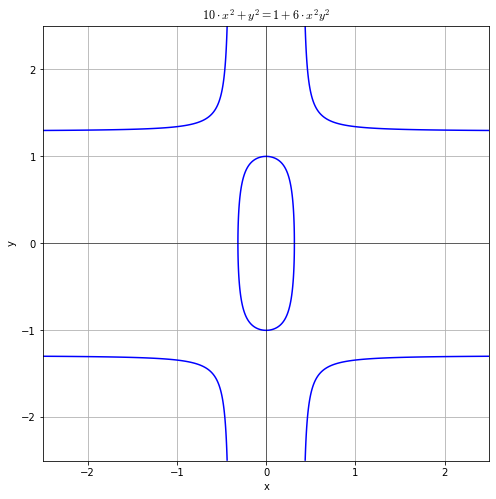

In [113]:
import numpy as np
import matplotlib.pyplot as plt

a = 10
d = 6
def equation(x, y):
    # a * x**2 + y**2 - 1 - d * x**2 * y**2 == 0
    return a * x**2 + y**2 - 1 - d * x**2 * y**2

# Create a grid of x and y values
x = np.linspace(-2.5, 2.5, 500)
y = np.linspace(-2.5, 2.5, 500)
X, Y = np.meshgrid(x, y)

# Calculate Z values based on the equation
Z = equation(X, Y)

# Plot the contour where Z = 0
plt.figure(figsize=(8, 8))
plt.contour(X, Y, Z, levels=[0], colors='blue')
plt.title(rf"${a}\cdot x^2 + y^2 = 1 + {d}\cdot x^2y^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
if SAVE_FIGURES: plt.savefig("./figures/ecc_twisted_edwards_over_R.png",format="png", dpi=300)
#plt.show()

### Computation in twisted Edwards curves 
TODO: Addition single equation

### Example: Ed25519/Edwards25519
Specified in EdDSA [RFC 8032](https://datatracker.ietf.org/doc/html/rfc8032#page-13) (used by age) and also allowed by NIST [FIPS 186-5](https://csrc.nist.gov/pubs/fips/186-5/final) as [Edwards25519](https://nvlpubs.nist.gov/nistpubs/SpecialPublications/NIST.SP.800-186.pdf).

$$
-x^2 + y^2 = 1 + dx^2 + y^2 \pmod p
$$

In [114]:
p = 0x7fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffed
FFp = GF(p)

In [115]:
assert p == 2**255 - 19

In [116]:
d = FFp(0x52036cee2b6ffe738cc740797779e89800700a4d4141d8ab75eb4dca135978a3)
a = FFp(0x7fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffec)

In [117]:
#d=37095705934669439343138083508754565189542113879843219016388785533085940283555
#a=-1

In [118]:
assert d == 37095705934669439343138083508754565189542113879843219016388785533085940283555

In [119]:
assert a+1 == p

Since sage does not directly support TwistedEdwards curves, the curve has to be converted
([cf.](https://neuromancer.sk/std/other/Ed25519))

In [120]:
# This curve is a Weierstrass curve (SAGE does not support TwistedEdwards curves) birationally equivalent to the intended curve.
# You can use the to_weierstrass and to_twistededwards functions to convert the points.
EC = EllipticCurve(FFp, (FFp(-1/48) * (a^2 + 14*a*d + d^2), FFp(1/864) * (a + d) * (-a^2 + 34*a*d - d^2)))

def to_weierstrass(a, d, x, y):
	return ((5*a + a*y - 5*d*y - d)/(12 - 12*y), (a + a*y - d*y -d)/(4*x - 4*x*y))

def to_twistededwards(a, d, u, v):
	y = (5*a - 12*u - d)/(-12*u - a + 5*d)
	x = (a + a*y - d*y -d)/(4*v - 4*v*y)
	return (x, y)
    
G = EC(*to_weierstrass(a, d, FFp(0x216936D3CD6E53FEC0A4E231FDD6DC5C692CC7609525A7B2C9562D608F25D51A), FFp(0x6666666666666666666666666666666666666666666666666666666666666658)))
EC.set_order(0x1000000000000000000000000000000014def9dea2f79cd65812631a5cf5d3ed * 0x08)


In [121]:
assert EC.trace_of_frobenius() == -221938542218978828286815502327069187962

## Koblitz curves
Are curves are usually defined over binary fields ($\mathbb{F}_{2^m}$) and aimed to be efficiently implementable in hardware. Due to their limited adoption, elliptic curves over binary fields have been deprecated in recent standards.  

## ECC standards 
<a id='std'></a>
There are multiple standards which standardized elliptic curves with their paramters to be used for ECC, e.g., 
* NIST [[FIPS 186-5]](https://csrc.nist.gov/pubs/fips/186-5/final) (last update 2023)
* SEC 2 [[SEC2v2](http://www.secg.org/sec2-v2.pdf)] (last update 2010)
* Brainpool [[RFC 5639](https://datatracker.ietf.org/doc/rfc5639/)] (last update 2010)
* ...

A good (but old) overview of standards and for choosing the right curves for ECC can be found on [SafeCurves](https://safecurves.cr.yp.to/index.html).

### NIST curves
NIST standardized different elliptic curves (*Edwards*, *Weierstrass*, *Montgomery*, and *Koblitz* curves). 
In its current version the recommended curves are defined over *prime fields*, i.e., $\mathbb{F}_p$ also written as $\mathrm{GF}(p)$ [[FIPS 186-5]](https://csrc.nist.gov/pubs/fips/186-5/final), [[SP 800-186]](https://csrc.nist.gov/pubs/sp/800/186/final). 
* With Feb. 2023 curves over *binary fields* ($\mathbb{F}_{2^m}$) have been depricated
    > Due to their limited adoption, elliptic curves over binary fields are deprecated
* With Feb. 2023 *Montgomery* curve Curve25519 (for ECDH) as well as *twisted Edwards* curve Edwards25519 (for EdDSA) are included in [[FIPS 186-5]](https://csrc.nist.gov/pubs/fips/186-5/final). [cf. [RFC 7748](https://datatracker.ietf.org/doc/html/rfc7748), [RFC 8032](https://datatracker.ietf.org/doc/html/rfc8032)]
    + The differences between NIST and IETF specifications have been analyzed here [[Taming the many EdDSAs](https://eprint.iacr.org/2020/1244.pdf),[The Provable Security of Ed25519: Theory and Practice](https://eprint.iacr.org/2020/823)] and test vectors are available [here](https://github.com/novifinancial/ed25519-speccheck).